<a href="https://colab.research.google.com/github/SergeyShchus/Automatic_GIS/blob/master/Notebook/Geopandas/Masking_clipping_raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import urllib
import urllib.parse
import requests

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepaths
outdir = r"content/"

# File locations
url_list = ["https://github.com/Automating-GIS-processes/CSC18/raw/master/data/Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif"]

# Create folder if it does no exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in url_list:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)
    # Download the file if it does not exist already
    if not os.path.exists(outfp):
        print("Downloading", fname)
        r = urllib.request.urlretrieve(url, outfp)

In [15]:
#@title
# Install OpticalRS. This also installs GeoPandas because GeoPandas is a dependency of OpticalRS
!apt-get install software-properties-common python-software-properties > /dev/null
!add-apt-repository ppa:ubuntugis/ppa -y > /dev/null
!apt-get update > /dev/null
!apt-get install -y --fix-missing python-gdal gdal-bin libgdal-dev > /dev/null
!pip2 install OpticalRS > /dev/null

! pip install geopandas

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

E: Package 'python-software-properties' has no installation candidate


In [16]:
!pip install rasterio
!pip install pycrs


import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
%matplotlib inline

# Data dir
data_dir = "/content/content"
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")


# Output raster
out_tif = os.path.join(data_dir, "Helsinki_Masked.tif")

  Created wheel for pycrs: filename=PyCRS-1.0.2-cp37-none-any.whl size=32683 sha256=a663158efd77609c289791e3177c8180ee0e613809249114463dd037fb2f5933
  Stored in directory: /root/.cache/pip/wheels/1a/c9/56/648f762bd41fdb03454be51b8a7069795925168833cb61f316
Successfully built pycrs


In [25]:
# Data dir
data_dir = "/content/content"
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")


# Output raster
out_tif = os.path.join(data_dir, "Helsinki_Masked.tif")

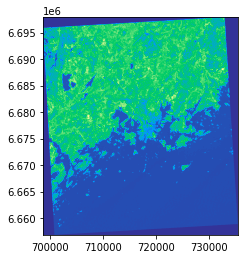

In [26]:
# Read the data
data = rasterio.open(fp)

from rasterio.plot import show

# Visualize the NIR band
show((data, 4), cmap='terrain')

In [19]:


# WGS84 coordinates
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

In [20]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((25.22000 60.00000, 25.22000 60.35000...


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [21]:
# Project the Polygon into same CRS as the grid 
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

<Projected CRS: +proj=tmerc +lat_0=0 +lon_0=-183 +k=0.9996 +x_0=50 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [23]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[-1040328.9192978777, 13005770.65252653], [-1023400.2975261931, 12969412.7083985], [-991450.4959099572, 12984121.919445757], [-1007997.9386615742, 13020603.381331535], [-1040328.9192978777, 13005770.65252653]]]}]


In [24]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

ValueError: ignored